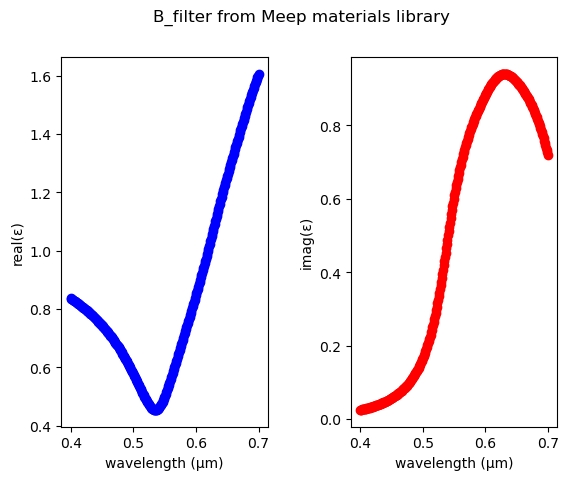

In [6]:
import meep as mp
import meep.adjoint as mpa
# from meep.materials import B_filter
import numpy as np
import matplotlib.pyplot as plt

um_scale = 1
resolution = 50

B_filter_frq1 = 1.818181818181818
B_filter_gam1 = 0.212353822772983
B_filter_sig1 = 0.03
B_filter_frq2 = 1.739130434782609
B_filter_gam2 = 0.212353822772983
B_filter_sig2 = 0.03
B_filter_frq3 = 1.666666666666667
B_filter_gam3 = 0.212353822772983
B_filter_sig3 = 0.03
B_filter_frq4 = 1.600000000000000
B_filter_gam4 = 0.212353822772983
B_filter_sig4 = 0.04
B_filter_frq5 = 1.538461538461538
B_filter_gam5 = 0.212353822772983
B_filter_sig5 = 0.03
B_filter_frq6 = 1.481481481481481
B_filter_gam6 = 0.212353822772983
B_filter_sig6 = 0.03
B_filter_frq7 = 1.428571428571429
B_filter_gam7 = 0.212353822772983
B_filter_sig7 = 0.04


B_filter_susc = [
    mp.LorentzianSusceptibility(frequency=B_filter_frq1, gamma=B_filter_gam1, sigma=B_filter_sig1),
    mp.LorentzianSusceptibility(frequency=B_filter_frq2, gamma=B_filter_gam2, sigma=B_filter_sig2),
    mp.LorentzianSusceptibility(frequency=B_filter_frq3, gamma=B_filter_gam3, sigma=B_filter_sig3),
    mp.LorentzianSusceptibility(frequency=B_filter_frq4, gamma=B_filter_gam4, sigma=B_filter_sig4),
    mp.LorentzianSusceptibility(frequency=B_filter_frq5, gamma=B_filter_gam5, sigma=B_filter_sig5),
    mp.LorentzianSusceptibility(frequency=B_filter_frq6, gamma=B_filter_gam6, sigma=B_filter_sig6),
    mp.LorentzianSusceptibility(frequency=B_filter_frq7, gamma=B_filter_gam7, sigma=B_filter_sig7),
]

B_filter = mp.Medium(
    epsilon=1.0, E_susceptibilities=B_filter_susc)


wvl_min = 0.4 * um_scale# units of μm
wvl_max = 0.7 * um_scale # units of μm
nwvls = 300
wvls = np.linspace(wvl_min, wvl_max, nwvls)

B_filter_epsilon = np.array([B_filter.epsilon(1/w)[0][0] for w in wvls])

plt.subplot(1,2,1)
plt.plot(wvls,np.real(B_filter_epsilon),'bo-')
plt.xlabel('wavelength (μm)')
plt.ylabel('real(ε)')

plt.subplot(1,2,2)
plt.plot(wvls,np.imag(B_filter_epsilon),'ro-')
plt.xlabel('wavelength (μm)')
plt.ylabel('imag(ε)')

plt.suptitle('B_filter from Meep materials library')
plt.subplots_adjust(wspace=0.4)
plt.savefig("epsilon")

-----------
Initializing structure...
time for choose_chunkdivision = 4.31538e-05 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 50
time for set_epsilon = 0.132431 s
-----------
run 0 finished at t = 16.13 (1613 timesteps)


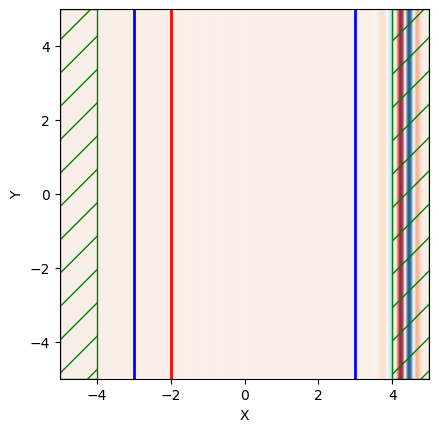

In [7]:
pml_layers = [mp.PML(thickness=1, direction = mp.X)]
cell_size = mp.Vector3(10,10)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

src = mp.GaussianSource(fcen,df)

sources = [mp.Source(src, component=mp.Ez, size=mp.Vector3(y=10), center=mp.Vector3(-2))]





geometry=[]


sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    k_point=mp.Vector3())

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-3, 0, 0), size=mp.Vector3(0, 10, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(3, 0, 0), size=mp.Vector3(0, 10, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)



sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-9))

plt.figure(dpi=100)
sim.plot2D(fields=mp.Ez)
plt.show()

In [8]:
straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

In [9]:
sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 4.69685e-05 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 50
     block, center = (2,0,0)
          size (0.3,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.149551 s
lorentzian susceptibility: frequency=1.42857, gamma=0.212354
lorentzian susceptibility: frequency=1.48148, gamma=0.212354
lorentzian susceptibility: frequency=1.53846, gamma=0.212354
lorentzian susceptibility: frequency=1.6, gamma=0.212354
lorentzian susceptibility: frequency=1.66667, gamma=0.212354
lorentzian susceptibility: frequency=1.73913, gamma=0.212354
lorentzian susceptibility: frequency=1.81818, gamma=0.212354
-----------
on time step 1160 (time=11.6), 0.00345023 s/step
on time step 2309 (time=23.09), 0.00348308 s/step
run 0 finished at t = 25.43 (2543 timesteps)
     block, center = (2,0,0)
          size (0.3,10,0)
          axes (

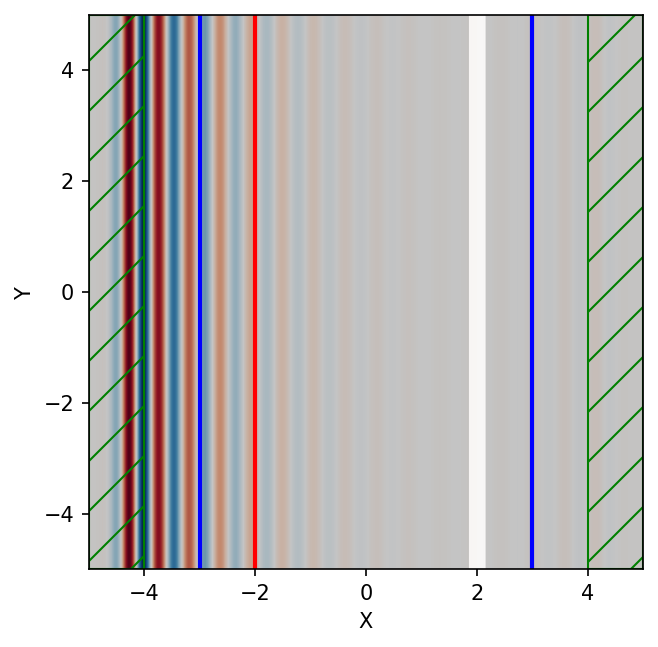

In [10]:
geometry = [mp.Block(
        mp.Vector3(0.3, 10, 0),
        center=mp.Vector3(2,0),
        material=B_filter
    )]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[B_filter],
                    k_point=mp.Vector3(0,0,0))

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(4 - 0.5/resolution, 0, 0) #pt는 transmitted flux region과 동일

sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-9))
# sim.run(until=100)

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D(fields=mp.Ez)
plt.show()

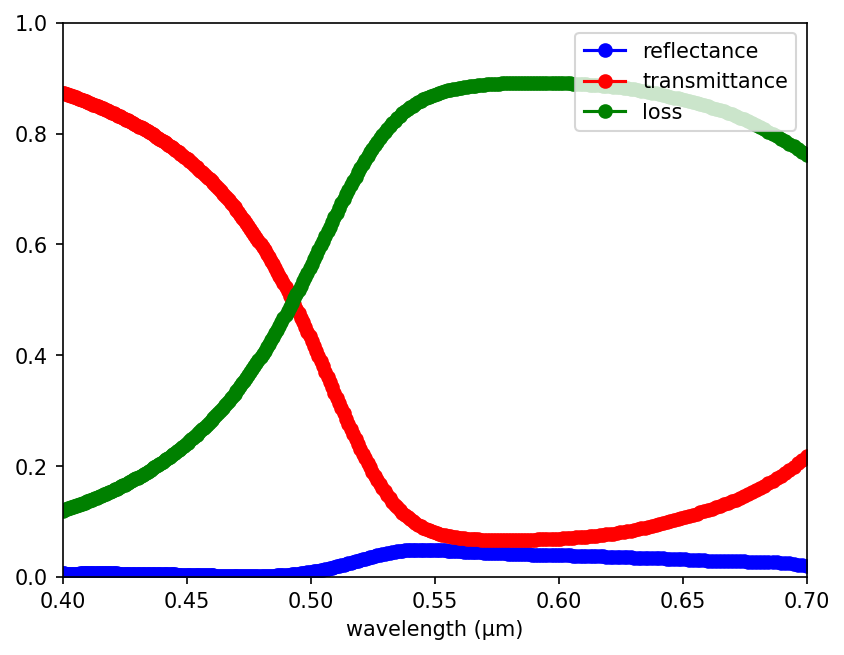

In [11]:
wl = [] #resolution 50
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

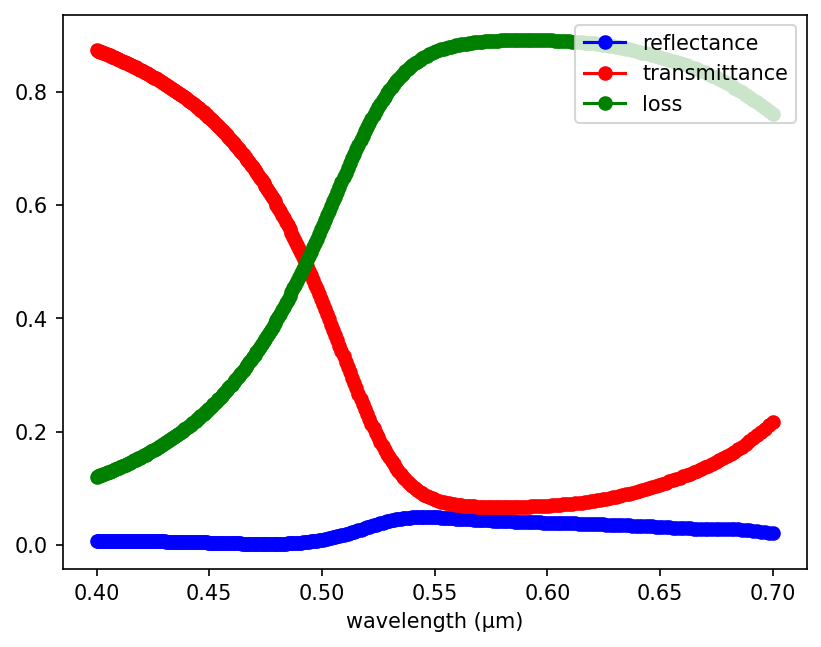

In [12]:
wl = [] #resolution20
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    # plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()